# Data and Model Explainability for Computer Vision with OpenVINO Toolkit™

**Please note: This is a work-in-progress reference kit, subject to updates.**

Understanding why computer vision models make certain predictions using data and model explainability can help us refine our models to be more efficient and performant. This tutorial demonstrates how to use data quality measurements and saliency maps to understand the predictions and performance of computer vision models during inference.
 
The specific techniques we will cover in this kit are:

**Data quality measurements**
- Inspect the properties of data corresponding to each label (e.g., Are all the cars appearing bigger in the frame of my data (because they’re near to the camera), or are there images of cars in a distance that are smaller, so my algorithm is able to detect both near and far cars)
- Check if the labels in the dataset are imbalanced, meaning that one label/class (“dog”, “person”) has much more data attributed to it than other labels (“cat”/”tree”).
- Check if bounding boxes are far from the label mean, meaning that the bounding boxes that were used are incorrect.

OpenVINO [datumaro](https://github.com/openvinotoolkit/datumaro/tree/develop) is a library for dataset management. We'll leverage code snippets from datumaro's tutorials, specifically on [data validation](https://github.com/openvinotoolkit/datumaro/blob/develop/notebooks/11_validate.ipynb), to generate these data quality measurements. 

**Saliency maps**
- Explainability algorithms can be used to generate heatmaps or saliency maps, showing which parts of the imag  a object classification or detection model used to make a prediction.

## Imports

We'll start by installing our requirements for this kit.

In [24]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Step 1: Download our dataset

In this step, we'll download the COCO 2017 dataset, focusing specifically on the object detection task with object segmentation output. Below, we run a few commands to fetch and unzip the dataset

In [1]:
!mkdir coco_dataset
!curl http://images.cocodataset.org/zips/val2017.zip --output coco_dataset/val2017.zip --silent
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip --output coco_dataset/annotations_trainval2017.zip --silent
!curl http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip --output coco_dataset/panoptic_annotations_trainval2017.zip --silent

In [2]:
!unzip -q coco_dataset/val2017.zip -d coco_dataset/images
!unzip -q coco_dataset/annotations_trainval2017.zip -d coco_dataset
!unzip -q coco_dataset/panoptic_annotations_trainval2017.zip -d coco_dataset
!unzip -q coco_dataset/annotations/panoptic_val2017.zip -d coco_dataset/annotations

## Step 2: Analyze the quality of the data

To start analyzing the quality of the data, we'll load in datumaro. Here, we'll import our local COCO dataseta and define our data subset as the 2017 validation data.

In [1]:
import datumaro as dm

dataset = dm.Dataset.import_from("coco_dataset", format="coco_instances")
subset = list(dataset.subsets().keys())[0]  # val2017

/home/ria/openvino_env/lib/python3.10/site-packages/datumaro/plugins/openvino_plugin/launcher.py:13: FutureWarning: OpenVINO Inference Engine Python API is deprecated and will be removed in 2024.0 release.For instructions on transitioning to the new API, please refer to https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
  from openvino.inference_engine import IECore
2024-02-09 13:19:44.335126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 13:19:44.335161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 13:19:44.335187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has a

In [2]:
subset

'val2017'

Let's start with briefly visualizing our data and the ground truth bounding boxes and semantic segmentation coming with the dataset.

In [3]:
def get_ids(dataset: dm.Dataset, subset: str):
    ids = []
    for item in dataset:
        if item.subset == subset:
            ids += [item.id]

    return ids


ids = get_ids(dataset, subset)
print("DatasetItem ids:", ids[:4])

DatasetItem ids: ['000000397133', '000000037777', '000000252219', '000000087038']


/tmp/ipykernel_2798341/3640283802.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


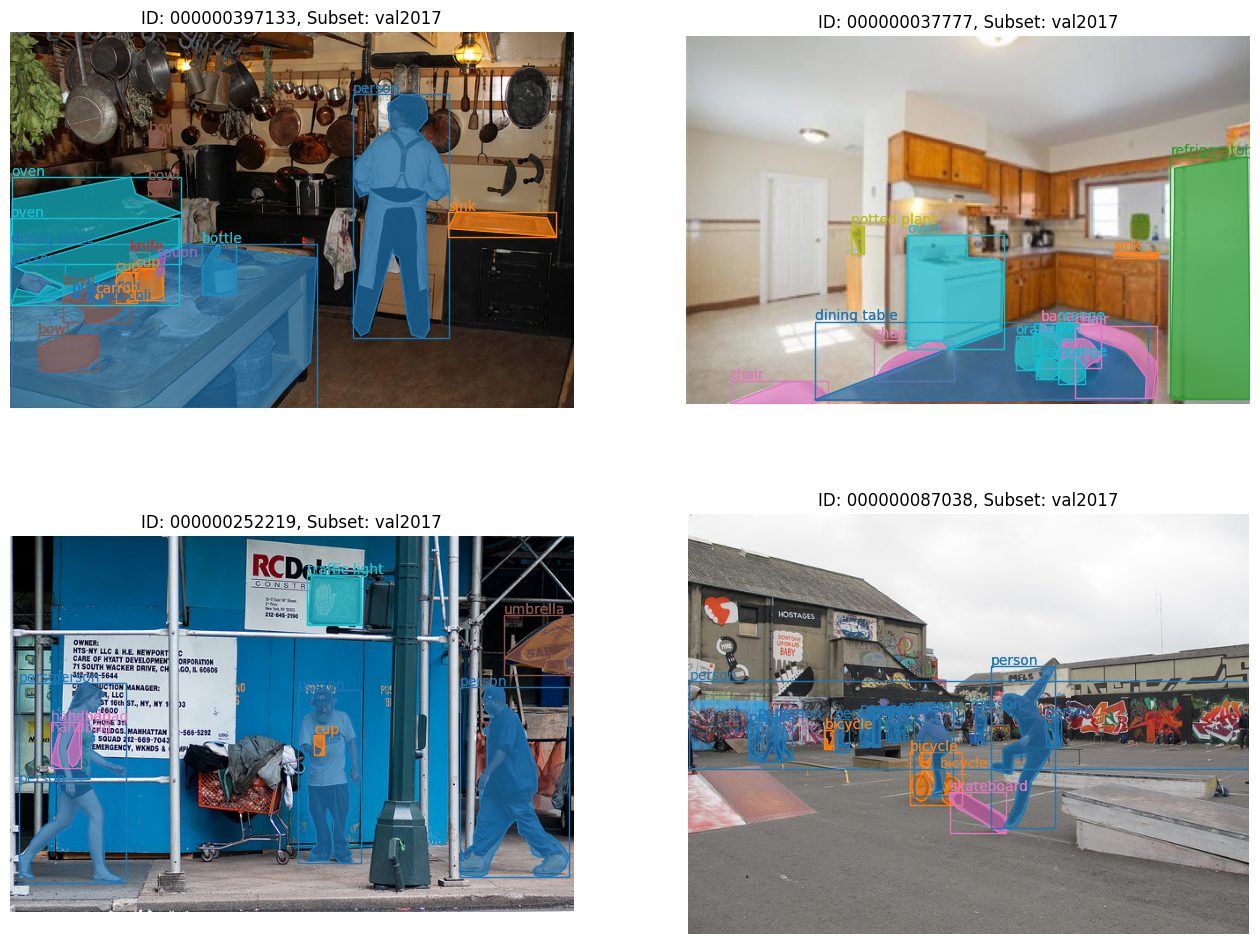

In [4]:
from datumaro.components.visualizer import Visualizer

visualizer = Visualizer(dataset, figsize=(16, 12), alpha=0.7)
fig = visualizer.vis_gallery(ids[:4], subset, grid_size=(None, None))
fig.show()

### Create an automated data quality report
Via datumaro's Visualizer, we can now see the outputs on a few images from the data. Let's now take a look at creating a validation report.

In [5]:
from datumaro.plugins.validators import DetectionValidator

extra_args = {
    "few_samples_thr": 100,
    "imbalance_ratio_thr": 5,
    "far_from_mean_thr": 20.0,
}

validator = DetectionValidator(**extra_args)

#Defining a function to create a summary validation report of the data
def validate(dataset):
    reports = validator.validate(dataset)

    print("Validation report summary:", reports["summary"])

    error_cnt = {}
    warning_cnt = {}
    for report in reports["validation_reports"]:
        if report["severity"] == "error":
            type = report["anomaly_type"]
            if error_cnt.get(type) is None:
                error_cnt[type] = 1
            else:
                error_cnt[type] += 1
        if report["severity"] == "warning":
            type = report["anomaly_type"]
            if warning_cnt.get(type) is None:
                warning_cnt[type] = 1
            else:
                warning_cnt[type] += 1
    print("The number of errors per error type: ", error_cnt)
    print("The number of warnings per warning type: ", warning_cnt)

    return reports


reports = validate(dataset)

Validation report summary: {'errors': 896832, 'warnings': 1282}
The number of errors per error type:  {'NegativeLength': 48, 'InvalidValue': 2, 'UndefinedAttribute': 896782}
The number of warnings per warning type:  {'MissingAnnotation': 1069, 'ImbalancedLabels': 1, 'FarFromLabelMean': 113, 'ImbalancedDistInLabel': 99}


As part of this kit, we'll selectively look into an error and a few of the warnings. Let's start with the error Negative Length by filtering the report and getting one of the first images that datumaro has identified contains a Negative Length anomaly.

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())

#Define a function to visualize the anomalies
def visualize_label_id(item, label_id=None):
    img = item.media.data.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for ann in item.annotations:
        if not label_id:
            continue
        if ann.id == label_id:
            x, y, w, h = ann.get_bbox()
            label_name = label_categories[ann.label].name
            x1, y1, x2, y2 = int(x), int(y), int(x + w), int(y + h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            cv2.putText(img, label_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))

    plt.imshow(img)
    plt.axis("off")
    plt.show()


for report in reports["validation_reports"]:
    if report["anomaly_type"] == "NegativeLength":
        item = dataset.get(report["item_id"], report["subset"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        visualize_label_id(item, label_id)

As we can see here, the bounding box for the skis appears to be an anomaly. Let's try treating the NegativeLength errors by rejecting these specific labels from annotations in the sample.

In [ ]:
from datumaro.components.annotation import AnnotationType, LabelCategories

label_categories = dataset.categories().get(AnnotationType.label, LabelCategories())

for report in reports["validation_reports"]:
    if report["anomaly_type"] == "NegativeLength":
        item = dataset.get(report["item_id"], report["subset"])
        print(report["description"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        neg_len_anns = []
        for ann in item.annotations:
            if ann.id == label_id:
                neg_len_anns.append(ann)
        for ann in neg_len_anns:
            item.annotations.remove(ann)

reports = validate(dataset)

It looks like that specific category of issues is fixed! Let's now specifically look into the warnings section, and dive deeper there. One of the labels we are seeing is imbalanced labels.

### Imbalanced Labels

The number of objects per label measures the distribution of the data objects across different categories or classes. We can review this metric to identify if the number of objects per label is skewed or uneven beyond expectations, in which case the data might not represent the real-world distribution of the categories.

There is an imbalance in the label distribution.


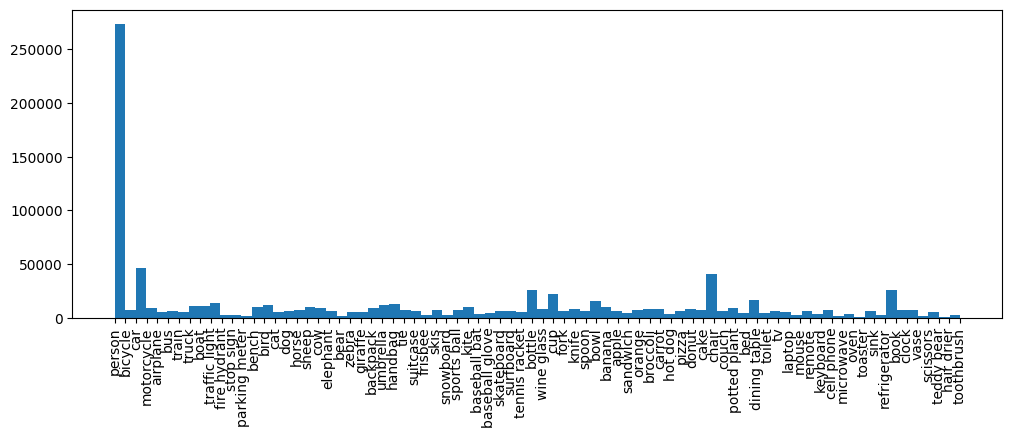

In [15]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "ImbalancedLabels":
        print(report["description"])

stats = reports["statistics"]

label_stats = stats["label_distribution"]["defined_labels"]
label_name, label_counts = zip(*[(k, v) for k, v in label_stats.items()])

plt.figure(figsize=(12, 4))
plt.hist(label_name, weights=label_counts, bins=len(label_name))
plt.xticks(rotation="vertical")
plt.show()

Taking a look at the above plot, we can identify that there's a much higher number of labels corresponding to the "person" category compared to other labels. We also see a smaller number of labels to data allocated to the stop sign and parking meter categories for example, which implies that our downstream model performance could be lower on these particular labels. 

If high performance on these categories is important to us for our use case, we may consider gathering and adding additional data for these categories as our next step. 

### Missing Annotation
Data samples with missing annotations can be problematic for the performance of a model. Although being a part of the dataset, these data samples are completely invaluable due to missing annotations that the model cannot leverage for training, or for evaluation during inference.

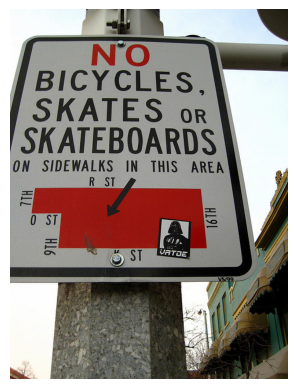

In [16]:
missing_annotations = []
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "MissingAnnotation":
        missing_annotations.append(dataset.get(report["item_id"], report["subset"]))

visualize_label_id(missing_annotations[0])

### FarFromLabelMean

Far From Label Mean measures the variation of the size of bounding boxes objects in our dataset used for AI applications. 
We can visualize the object size corresponding to each label, including the overall height and width of objects in relation to each other.  

When annotating images, the ground truth bounding boxes are typically created to snap around individuals’ figures,  with all of the object size results being balanced.  

However, in certain cases, we can have anomalous bounding boxes that are too thin or too tall, and don't accurately capture the object as part of the dataset.

In [ ]:
for report in reports["validation_reports"]:
    if report["anomaly_type"] == "FarFromLabelMean":
        print(report["description"])
        item = dataset.get(report["item_id"], report["subset"])
        label_id = [int(s) for s in str.split(report["description"], "'") if s.isdigit()][0]
        visualize_label_id(item, label_id)

# Model Explainability for OpenVINO-optimized Yolov8 and Ultralytics Heatmaps


For many different use cases, we'll want to leverage optimized object detection models with a smaller model footprint and faster inference. But can we also add explainability to these optimized models? 

Let's explore this with using the OpenVINO™ YOLOv8 model FP16 model via the Ultralytics API. Ultralytics' YOLOv8 API provides convenient model exporting to different formats, including OpenVINO IR. model.export is responsible for the model conversion. We need to specify the format, and additionally, we could preserve dynamic shapes in the model. It would limit us to use CPU only, so we're not doing this. Also, we specify we want to use half-precision (FP16) to get better performance.

In [ ]:
from pathlib import Path
from ultralytics import YOLO

#Specify our models path
models_dir = Path('./model')
models_dir.mkdir(exist_ok=True)

DET_MODEL_NAME = "yolov8m"
det_model = YOLO(models_dir / f'{DET_MODEL_NAME}.pt')
label_map = det_model.model.names

# Load our Yolov8 object detection model
ov_model_path = Path(f"model/{DET_MODEL_NAME}_openvino_model/{DET_MODEL_NAME}.xml")
if not ov_model_path.exists():
    # export model to OpenVINO format
    out_dir = det_model.export(format="openvino", dynamic=False, half=True)

model = YOLO('model/yolov8m_openvino_model/')

Next, let's generate a heatmap with the Ultralytics Yolov8 API and Intel OpenVINO.

For object classification and detection models, a **heatmap**, or **saliency map**, shows where a model is "focusing" on a certain part of the image to make a prediction/inference. Higher intensities of color indicate a greater focus than the model is placing on that part of the image, and cooler tones indicate a lower focus, pertaining to the detected object.

Let's consider an example of a sample video of elephants.

In [ ]:
#Source: https://docs.ultralytics.com/guides/heatmaps/#real-world-applications

from ultralytics import YOLO
from ultralytics.solutions import heatmap
import cv2

model = YOLO('model/yolov8m_openvino_model/')
cap = cv2.VideoCapture("footage_of_an_elephant (1080p).mp4")
assert cap.isOpened(), "Error reading video file"
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

# Video writer
video_writer = cv2.VideoWriter("heatmap_output.avi",
                               cv2.VideoWriter_fourcc(*'mp4v'),
                               fps,
                               (w, h))

# Init heatmap
heatmap_obj = heatmap.Heatmap()
heatmap_obj.set_args(colormap=cv2.COLORMAP_PARULA,
                     imw=w,
                     imh=h,
                     view_img=True,
                     shape="circle")

while cap.isOpened():
    success, im0 = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break
    tracks = model.track(im0, persist=True, show=False)

    im0 = heatmap_obj.generate_heatmap(im0, tracks)
    video_writer.write(im0)

cap.release()
video_writer.release()
cv2.destroyAllWindows()

![example-heatmap](https://github.com/openvinotoolkit/openvino_notebooks/assets/22090501/9d87d228-e700-425e-86d0-0f21db22ba9d)

Here, we have our heatmap generated for our optimized Yolov8 model with the yellowish to blue areas indicating the focus of the model! Despite leveraging a model with smaller model size, we're still able to enable explainabiility for our optimized models.

## Benchmarking
For more information on how to performance benchmark OpenVINO YOLOv8 models, visit this notebook.